In [3]:
pip install catboost

   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.5/102.5 MB 1.5 MB/s eta 0:01:07
   ---------------------------------------- 1.0/102.5 MB 2.1 MB/s eta 0:00:49
    --------------------------------------- 1.6/102.5 MB 2.3 MB/s eta 0:00:44
    --------------------------------------- 2.4/102.5 MB 2.5 MB/s eta 0:00:41
   - -------------------------------------- 2.9/102.5 MB 2.5 MB/s eta 0:00:41
   - -------------------------------------- 3.1/102.5 MB 2.5 MB/s eta 0:00:40
   - -------------------------------------- 3.4/102.5 MB 2.1 MB/s eta 0:00:47
   - -------------------------------------- 4.2/102.5 MB 2.3 MB/s eta 0:00:43
   - -------------------------------------- 4.7/102.5 MB 2.4 MB/s eta 0:00:42
   -- ------------------------------------- 5.5/102.5 MB 2.5 MB/s eta 0:00:40
   -- ------------------------------------- 6.3/102.5 MB 2.6 MB/s eta 0:00:38
   -- ------------------------------------- 6.8/102.5 MB 2.6 MB/s eta 0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 4.2 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.5 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
from pandas import read_excel, DataFrame, read_csv, Series
import pandas as pd
#import catboost as cb
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
#from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score
import pylab as pl
import time # для работы со временем
import pandas.io.sql as psql
import pickle # для сохранения/загр
import datetime
import matplotlib.pyplot as plt
# заставляем рисунки встраиваться в блокнот
%matplotlib inline

In [19]:
# чтение из эксель
w = {'id': object} 
train = pd.read_csv(open('train.csv', 'rb'),dtype = w)
test = pd.read_csv(open('test.csv', 'rb'),dtype = w)

train

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
...,...,...,...,...,...,...,...,...,...
18519,18519,3.0,No,7.0,3.0,No,9.0,7.0,Extrovert
18520,18520,1.0,NaN,6.0,7.0,No,6.0,5.0,Extrovert
18521,18521,7.0,Yes,1.0,1.0,Yes,1.0,NaN,Introvert
18522,18522,NaN,Yes,1.0,0.0,Yes,5.0,2.0,Introvert


In [27]:
train.info()
train.shape,test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  object 
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), object(4)
memory usage: 1.3+ MB


((18524, 9), (6175, 8))

In [33]:
train['Personality'].value_counts()

Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64

In [75]:
train['target'] = np.where(train['Personality'] == 'Introvert',1,0)
train['target'].value_counts(),\
round((train['target'].value_counts()[1]/(train['target'].value_counts()[1]+train['target'].value_counts()[0]))*100,2)

(target
 0    13699
 1     4825
 Name: count, dtype: int64,
 26.05)

In [85]:
train['Time_spent_Alone'].describe()

count    17334.000000
mean         3.137764
std          3.003786
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         11.000000
Name: Time_spent_Alone, dtype: float64

In [95]:
train['Drained_after_socializing'].value_counts()

Drained_after_socializing
No     13313
Yes     4062
Name: count, dtype: int64

In [91]:
for i in [train,test]:
    i['Stage_fear'] = np.where(i['Stage_fear'] == 'Yes',1,0)

In [97]:
for i in [train,test]:
    i['Drained_after_socializing'] = np.where(i['Drained_after_socializing'] == 'Yes',1,0)

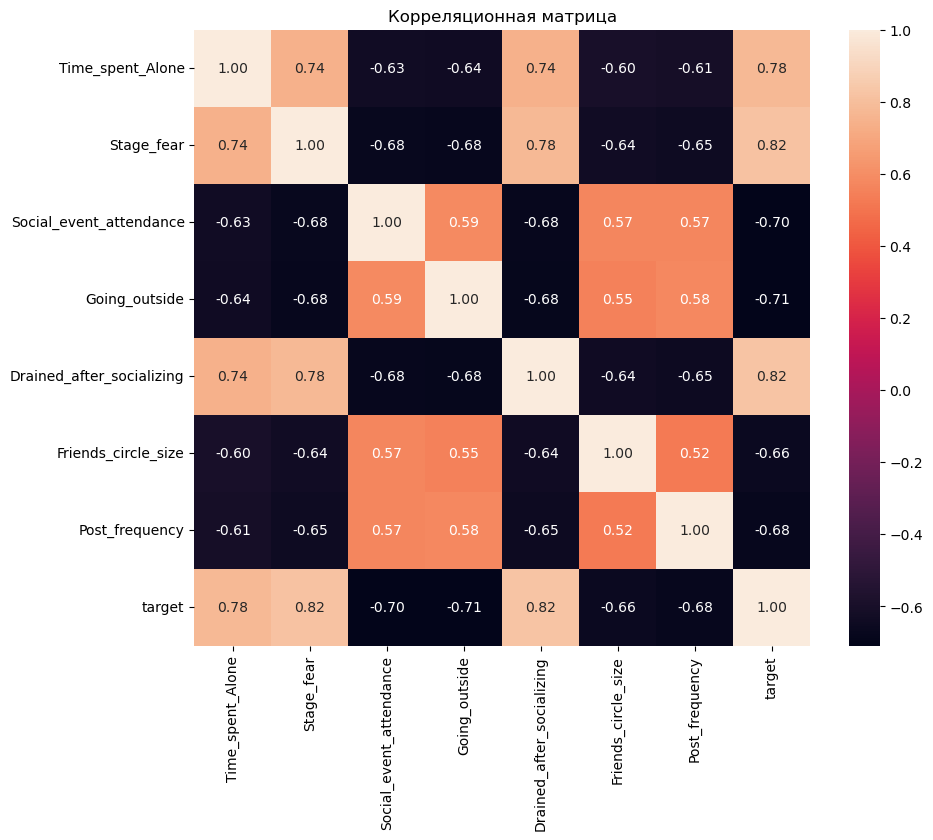

In [169]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(train.drop(['Personality','id'],axis=1).corr(), annot=True, fmt=".2f", square=True)
plt.title("Корреляционная матрица")
plt.show()

In [409]:
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Разделим данные
X = train.drop(['target','id', 'Personality'], axis=1)
y = train['target']

In [411]:
#df_coef = np.sign(train.drop(['id', 'Personality'],axis=1).corr()['target'])
#df_coef.drop('target',inplace=True)
#df_coef

In [413]:
#X_matched = X[df_coef.index]
#X_new = X_matched*df_coef
#X_new

In [415]:
#X['sum'] = X_new.sum(axis=1, numeric_only=True)
#X['sum']

In [417]:
#pd.concat([X,y],axis=1).corr()

#### кластеризация

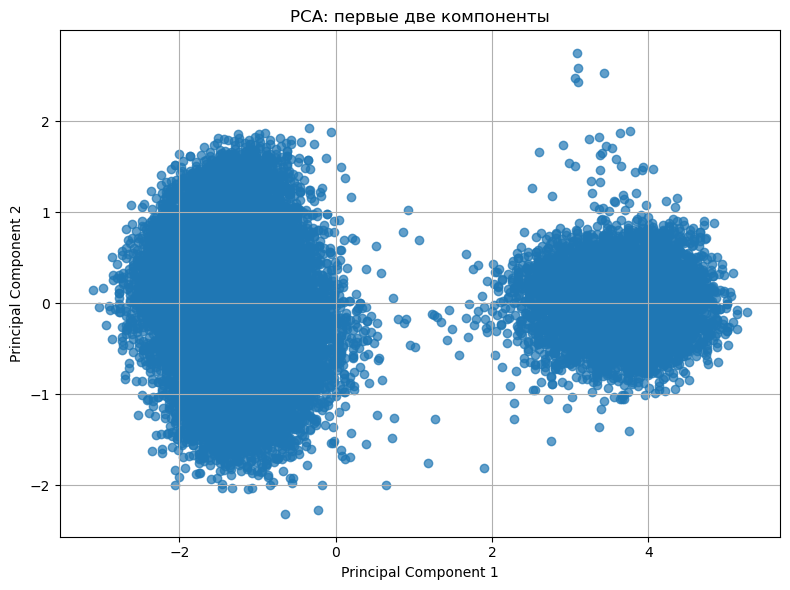

In [419]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import KNNImputer

# Допустим, у нас есть DataFrame X с числовыми признаками
# X = ...

imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)

# 1. Масштабируем данные (PCA чувствителен к масштабу)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 2. PCA до 2 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. Преобразуем результат в DataFrame для удобства
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# 4. Рисуем график
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: первые две компоненты')
plt.grid(True)
plt.tight_layout()
plt.show()


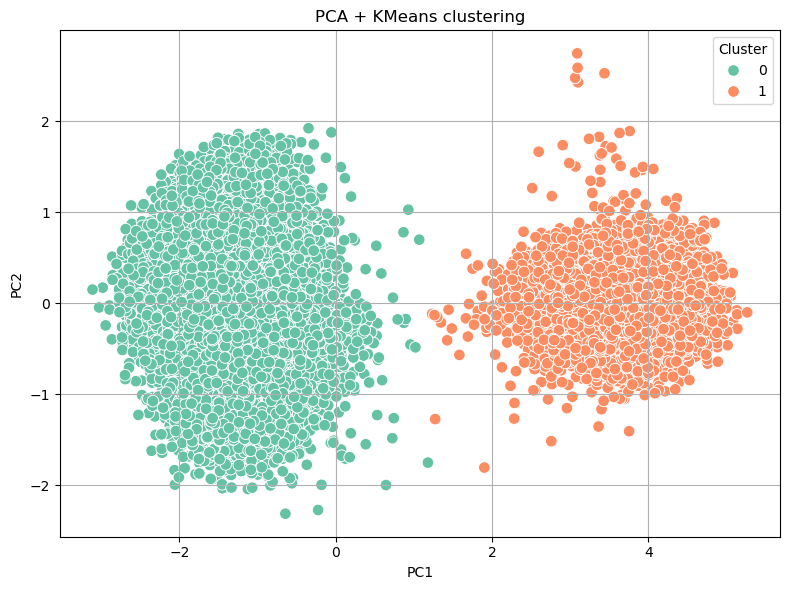

In [420]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
# 3. Кластеризация KMeans
kmeans = KMeans(n_clusters=2, random_state=42)  # можно поменять число кластеров
clusters = kmeans.fit_predict(X_pca)

# 4. Визуализация
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# График
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=70)
plt.title('PCA + KMeans clustering')
plt.grid(True)
plt.tight_layout()
plt.show()

In [429]:
clusters

array([0, 0, 1, ..., 1, 1, 0])

In [433]:
X_copy = pd.DataFrame(X_imputed,columns = X.columns)
X_copy['cluster'] = clusters

In [561]:
from sklearn.neighbors import KNeighborsClassifier

# Стандартизация признаков (важна для KNN!)

X_train, X_test, y_train, y_test = train_test_split(X_copy, y, test_size=0.3, random_state=42,stratify = y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучаем модель
knn = KNeighborsClassifier(n_neighbors=15)  # Можно тюнить n_neighbors
knn.fit(X_train_scaled, y_train)

# Предсказание
y_pred = knn.predict(X_test_scaled)

# Метрики
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4110
           1       0.94      0.94      0.94      1448

    accuracy                           0.97      5558
   macro avg       0.96      0.96      0.96      5558
weighted avg       0.97      0.97      0.97      5558



In [563]:
score = cross_val_score(knn, X_copy, y, cv=3, scoring='accuracy')
score.mean()

0.9687434091945372

In [565]:

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Укажем категориальные признаки по названиям
cat_features = ['Drained_after_socializing', 'Stage_fear','cluster']

for i in cat_features:
    X_copy[i] = X_copy[i].astype('int')

# Разделим на train/test
X_train, X_test, y_train, y_test = train_test_split(X_copy, y, test_size=0.3, random_state=42,stratify = y)

# Обучим модель CatBoost
cb = CatBoostClassifier(
    verbose=0,
    cat_features=cat_features,
    l2_leaf_reg=8,
    learning_rate=0.01,
    depth=7,
    iterations=1500,
    random_state=42
)

cb.fit(X_train, y_train)

# Предсказания
y_pred = cb.predict(X_test)

# Оценка качества
print(classification_report(y_test, y_pred))

# -----------------------------
# ВАЖНОСТЬ ПРИЗНАКОВ
# -----------------------------

# Получим важности и выведем таблицу
importances = cb.get_feature_importance()
features = X_copy.columns

fi_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nВажность признаков:")
print(fi_df)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4110
           1       0.94      0.94      0.94      1448

    accuracy                           0.97      5558
   macro avg       0.96      0.96      0.96      5558
weighted avg       0.97      0.97      0.97      5558


Важность признаков:
                     Feature  Importance
7                    cluster   34.245069
5        Friends_circle_size   13.276231
3              Going_outside   13.088348
2    Social_event_attendance   13.007391
0           Time_spent_Alone   12.758725
6             Post_frequency   10.931239
1                 Stage_fear    1.701840
4  Drained_after_socializing    0.991156


In [667]:
X_copy1 = X_copy.drop('cluster',axis=1)

In [671]:
cat_features = ['Drained_after_socializing', 'Stage_fear']

cb = CatBoostClassifier(
    verbose=0,
    cat_features=cat_features,
    l2_leaf_reg=8,
    learning_rate=0.01,
    depth=7,
    iterations=1500,
    random_state=42
)

score = cross_val_score(cb, X_copy1, y, cv=3, scoring='accuracy')
score.mean()

0.968905335027784

In [687]:
X_copy

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,cluster
0,0.0,0,6.0,4.0,0,15.0,5.0,0
1,1.0,0,7.0,3.0,0,10.0,8.0,0
2,6.0,1,1.0,0.0,0,3.0,0.0,1
3,3.0,0,7.0,3.0,0,11.0,5.0,0
4,1.0,0,4.0,4.0,0,13.0,6.4,0
...,...,...,...,...,...,...,...,...
18519,3.0,0,7.0,3.0,0,9.0,7.0,0
18520,1.0,0,6.0,7.0,0,6.0,5.0,0
18521,7.0,1,1.0,1.0,1,1.0,1.2,1
18522,7.2,1,1.0,0.0,1,5.0,2.0,1


In [802]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

# Укажем категориальные признаки
cat_features = ['Drained_after_socializing', 'Stage_fear']

#X.drop(['sum'],axis=1,inplace=True)

# Разделим данные
X_train, X_test, y_train, y_test = train_test_split(X_copy.drop('cluster',axis=1), y, test_size=0.3, random_state=42,stratify = y)

# LightGBM требует категориальные признаки в виде 'category'
'''X_train = X_train.copy
X_test = X_test.copy()
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')'''

cat_features = ['Drained_after_socializing', 'Stage_fear']
cat_feature_indices = [X_copy.columns.get_loc(col) for col in cat_features]

# Обучим модель
lgbm = lgb.LGBMClassifier(categorical_feature = cat_feature_indices,
    learning_rate=0.010911569195145314,
    #categorical_features = cat_features,
    n_estimators=501,
    num_leaves=23,
    reg_lambda=7.168055317097198,
    max_depth=4,
    random_state=42,
    force_col_wise=True,
    verbose = -1,
    #feature_fraction = 1
    #boosting_type = 'goss'
)#'max_depth': 4, 'learning_rate': 0.010911569195145314, 'n_estimators': 501, 'reg_lambda': 7.168055317097198, 'num_leaves': 23

lgbm.fit(X_train, y_train)

# Предсказания и метрики
y_pred = lgbm.predict(X_test)
print(classification_report(y_test, y_pred))

# -----------------------------
# ВАЖНОСТЬ ПРИЗНАКОВ
# -----------------------------

# Получаем важности
importances = lgbm.feature_importances_
features = X_copy.drop('cluster',axis=1).columns

fi_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nВажность признаков:")
print(fi_df)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4110
           1       0.94      0.94      0.94      1448

    accuracy                           0.97      5558
   macro avg       0.96      0.96      0.96      5558
weighted avg       0.97      0.97      0.97      5558


Важность признаков:
                     Feature  Importance
0           Time_spent_Alone        1538
2    Social_event_attendance        1133
5        Friends_circle_size        1079
3              Going_outside        1013
6             Post_frequency         947
1                 Stage_fear         226
4  Drained_after_socializing          79


In [808]:
score = cross_val_score(lgbm, X_copy.drop(['cluster'],axis=1), y, cv=3, scoring='accuracy')
score.mean()

0.9690133147276004

In [776]:
#imputer = KNNImputer(n_neighbors=5)
x_valid = test.drop('id',axis = 1)
x_valid = imputer.transform(x_valid)

x_valid = pd.DataFrame(x_valid,columns = X_copy.drop('cluster',axis=1).columns)

In [777]:
x_valid['Personality'] = lgbm.predict(x_valid)
x_valid['id'] = test['id']

x_valid[['id','Personality']]

,id,Personality
0,18524,0
1,18525,1
2,18526,0
3,18527,0
4,18528,1
...,...,...
6170,24694,0
6171,24695,1
6172,24696,0
6173,24697,0


In [780]:
x_valid['Personality'] = np.where(x_valid['Personality'] == 1, 'Introvert','Extrovert')
x_valid[['id','Personality']]

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
...,...,...
6170,24694,Extrovert
6171,24695,Introvert
6172,24696,Extrovert
6173,24697,Extrovert


In [796]:
x_valid[['id','Personality']].to_csv('valid_intro.csv',index=False, encoding='utf-8')

In [814]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# RFECV с 5-фолд кросс-валидацией
rfecv = RFECV(estimator=lgbm,
              step=1,
              cv=StratifiedKFold(3),
              scoring='accuracy',
              n_jobs=-1)

rfecv.fit(X_copy.drop('cluster',axis=1), y)

# Посмотрим результат
print(f"Оптимальное количество признаков: {rfecv.n_features_}")
print("Выбранные признаки:")
print(X_copy.drop('cluster',axis=1).columns[rfecv.support_])

Оптимальное количество признаков: 7
Выбранные признаки:
Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency'],
      dtype='object')


In [709]:
import optuna
#from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

# Функция, которую будет минимизировать Optuna
def objective(trial):
    # Определяем диапазоны для гиперпараметров
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        #'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        #'gamma': trial.suggest_float('gamma', 0, 5),
        #'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
        #'use_label_encoder': False,
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        
    }

    model = lgb.LGBMClassifier(**params)

    # Кросс-валидация
    score = cross_val_score(model, X_copy.drop('cluster',axis=1), y, cv=3, scoring='accuracy')
    return score.mean()

# Создаём исследование
study = optuna.create_study(direction="maximize")  # хотим максимизировать accuracy
study.optimize(objective, n_trials=50, timeout=300)  # 50 попыток или 5 минут

# Результаты
print("🥇 Лучшие параметры:")
print(study.best_params)
print("🏆 Лучшая точность (CV):", study.best_value)

[I 2025-07-23 13:29:22,428] A new study created in memory with name: no-name-ab93d4f3-ccd4-4d4d-a360-e92853bdd6ea
[I 2025-07-23 13:29:25,270] Trial 0 finished with value: 0.9681495208455466 and parameters: {'max_depth': 7, 'learning_rate': 0.043334419862040126, 'n_estimators': 416, 'reg_lambda': 2.69522916005358, 'num_leaves': 41}. Best is trial 0 with value: 0.9681495208455466.
[I 2025-07-23 13:29:31,308] Trial 1 finished with value: 0.9677716618425535 and parameters: {'max_depth': 5, 'learning_rate': 0.058389036517902566, 'n_estimators': 977, 'reg_lambda': 6.310515275460567, 'num_leaves': 24}. Best is trial 0 with value: 0.9681495208455466.
[I 2025-07-23 13:29:37,327] Trial 2 finished with value: 0.9671778609265181 and parameters: {'max_depth': 5, 'learning_rate': 0.06992174219777214, 'n_estimators': 1098, 'reg_lambda': 6.170820578531804, 'num_leaves': 32}. Best is trial 0 with value: 0.9681495208455466.
[I 2025-07-23 13:29:43,624] Trial 3 finished with value: 0.9686353857782429 and 

🥇 Лучшие параметры:
{'max_depth': 4, 'learning_rate': 0.010911569195145314, 'n_estimators': 501, 'reg_lambda': 7.168055317097198, 'num_leaves': 23}
🏆 Лучшая точность (CV): 0.9690133147276004


In [575]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('knn', knn),
        ('cb', cb),
        ('lgbm', lgbm)
    ],
    voting='soft'  # или 'soft' — тогда нужно, чтобы модели умели predict_proba
)

#voting_clf.fit(X_train, y_train)
#y_pred = voting_clf.predict(X_test)

score = cross_val_score(voting_clf, X_copy, y, cv=3, scoring='accuracy')
score.mean()

#print("Accuracy:", accuracy_score(y_test, y_pred))

0.9688513539211714

In [617]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier

# Классификация
clf = ExtraTreesClassifier(n_estimators=500, max_depth=6, random_state=42)
rf = RandomForestClassifier(
    n_estimators=580,        # количество деревьев
    max_depth=9,             # максимальная глубина деревьев
    random_state=42
)

score = cross_val_score(rf, X_copy, y, cv=3, scoring='accuracy')
score.mean()

0.968905335027784

In [635]:
LogisticRegression?

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='deprecated',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices co

In [639]:
from sklearn.linear_model import LogisticRegression
# Создаем пайплайн
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l1', C=10, solver='saga', max_iter=1000, random_state=42 ))
])

# Кросс-валидация по 5 фолдам
cv_scores = cross_val_score(pipeline, X_copy, y, cv=3, scoring='accuracy')

# Выводим результаты
print(f"Кросс-валидация, точность по фолдам: {cv_scores}")
print(f"Средняя точность: {np.mean(cv_scores):.4f}")

Кросс-валидация, точность по фолдам: [0.96825911 0.96680162 0.97116942]
Средняя точность: 0.9687
